In [2]:
# Importing Libraries

import numpy as np
import pandas as pd
import os

# Libraries for Plotting

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree

# Libraries for Data Preprocessing

from sklearn import preprocessing

# Libraries for Modelling

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# Library for copying

import copy

In [3]:
# Identifying current directory

current_directory = os.getcwd()
print(current_directory)

/Users/suparnaroy/Library/CloudStorage/GoogleDrive-roysuparna.sr@gmail.com/Other computers/My Laptop/All about Manchester/My Course/Dissertation/Notebooks


In [4]:
# Changing current directory to the path consisting Datasets

os.chdir("/Users/suparnaroy/Library/CloudStorage/GoogleDrive-roysuparna.sr@gmail.com/Other computers/My Laptop/All about Manchester/My Course/Dissertation/Datasets")

In [5]:
# Reading the dataset of Meat Consumption into a dataframe

MeatVolume = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Meat.xlsx")
MeatVolume.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Fresh Meat,21.15,21.26,21.71,21.78,21.45,21.93,22.51,23.13,23.70,24.21,24.78
1,Meat Substitutes,0.13,0.16,0.20,0.24,0.25,0.27,0.30,0.32,0.35,0.37,0.39
2,Processed Meat,16.03,15.57,15.32,14.98,14.53,14.83,15.11,15.44,15.80,16.13,16.50
3,Total,37.31,36.98,37.23,37.00,36.23,37.03,37.92,38.89,39.85,40.71,41.68


### Data Preparation

In [6]:
MeatVolume.drop(['2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted
MeatVolume.rename(columns={"Unnamed: 0":"Meat_Type"},inplace= True)
MeatVolume.set_index('Meat_Type', inplace= True)
MeatVolume.drop(['Total'], axis = 0, inplace= True) # Dropping the Total row
MeatVolume.head()

,2018,2019,2020,2021
Meat_Type,,,,
Fresh Meat,21.15,21.26,21.71,21.78
Meat Substitutes,0.13,0.16,0.20,0.24
Processed Meat,16.03,15.57,15.32,14.98


In [7]:
MeatVolume.reset_index(inplace= True)

In [8]:
# Changing the data format from Wide => Long

Meat_Vol_new = pd.melt(MeatVolume, id_vars = 'Meat_Type', value_vars= ['2018', '2019', '2020', '2021'], value_name= 'Volume_in_bn_kg', var_name= 'Year')
Meat_Vol_new.head()

,Meat_Type,Year,Volume_in_bn_kg
0,Fresh Meat,2018,21.15
1,Meat Substitutes,2018,0.13
2,Processed Meat,2018,16.03
3,Fresh Meat,2019,21.26
4,Meat Substitutes,2019,0.16


In [9]:
# Changing datatype of Year as datetime

Meat_Vol_new['Year'] = pd.to_datetime(Meat_Vol_new['Year']).dt.strftime('%Y')
Meat_Vol_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Meat_Type        12 non-null     object 
 1   Year             12 non-null     object 
 2   Volume_in_bn_kg  12 non-null     float64
dtypes: float64(1), object(2)
memory usage: 416.0+ bytes


In [10]:
# Changing the data format from Long => Wide

Meat_Vol = Meat_Vol_new.pivot(index = 'Year', values= 'Volume_in_bn_kg', columns = 'Meat_Type').reset_index()
Meat_Vol.head()

Meat_Type,Year,Fresh Meat,Meat Substitutes,Processed Meat
0,2018,21.15,0.13,16.03
1,2019,21.26,0.16,15.57
2,2020,21.71,0.20,15.32
3,2021,21.78,0.24,14.98


In [11]:
# Reading the dataset of Beef & Veal Consumption into a dataframe

Beef_Vol = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Beef  Veal.xlsx")
Beef_Vol.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Total,5.12,5.07,5.17,5.12,5.05,5.14,5.29,5.42,5.52,5.61,5.71


In [12]:
Beef_Vol.drop(['Unnamed: 0', '2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted
Beef_Vol.head()

,2018,2019,2020,2021
0,5.12,5.07,5.17,5.12


In [13]:
# Changing format of the dataset from Wide => Long

Beef_Vol_new = pd.melt(Beef_Vol, value_vars=['2018', '2019', '2020', '2021'], value_name= 'Beef and Veal', var_name= "Year")
Beef_Vol_new.head()

,Year,Beef and Veal
0,2018,5.12
1,2019,5.07
2,2020,5.17
3,2021,5.12


In [14]:
# Merging Meat Volume Dataset with different type(s) of Fresh Meat: Beef and Veal

merged_df = pd.merge(Meat_Vol, Beef_Vol_new, on= 'Year')
merged_df.head()

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal
0,2018,21.15,0.13,16.03,5.12
1,2019,21.26,0.16,15.57,5.07
2,2020,21.71,0.20,15.32,5.17
3,2021,21.78,0.24,14.98,5.12


In [15]:
# Reading the dataset of Poultry Consumption into a dataframe

Poultry_Vol = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Poultry_bn_kg.xlsx")
Poultry_Vol.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Total,8.24,8.23,8.39,8.39,8.08,8.26,8.48,8.76,9.04,9.26,9.54


In [16]:
Poultry_Vol.drop(['Unnamed: 0', '2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted

# Changing format of the dataset from Wide => Long

Poul_Vol = pd.melt(Poultry_Vol, value_vars=['2018', '2019', '2020', '2021'], value_name= 'Poultry', var_name= "Year")
Poul_Vol.head()

,Year,Poultry
0,2018,8.24
1,2019,8.23
2,2020,8.39
3,2021,8.39


In [17]:
# Merging Meat Volume Dataset with different type(s) of Fresh Meat: Poultry

merged_df = pd.merge(merged_df, Poul_Vol, on= 'Year')
merged_df.head()

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal,Poultry
0,2018,21.15,0.13,16.03,5.12,8.24
1,2019,21.26,0.16,15.57,5.07,8.23
2,2020,21.71,0.20,15.32,5.17,8.39
3,2021,21.78,0.24,14.98,5.12,8.39


In [18]:
# Reading the dataset of Pork Consumption into a dataframe

Pork_Vol = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Pork_bn_kg.xlsx")
Pork_Vol.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Total,5.09,5.23,5.39,5.48,5.54,5.67,5.82,5.97,6.1,6.22,6.35


In [19]:
Pork_Vol.drop(['Unnamed: 0', '2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted

# Changing format of the dataset from Wide => Long

Pork_Vol_new = pd.melt(Pork_Vol, value_vars=['2018', '2019', '2020', '2021'], value_name= 'Pork', var_name= "Year")
Pork_Vol_new.head()

,Year,Pork
0,2018,5.09
1,2019,5.23
2,2020,5.39
3,2021,5.48


In [20]:
# Merging Meat Volume Dataset with different type(s) of Fresh Meat: Pork

merged_df = pd.merge(merged_df, Pork_Vol_new, on= 'Year')
merged_df.head()

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal,Poultry,Pork
0,2018,21.15,0.13,16.03,5.12,8.24,5.09
1,2019,21.26,0.16,15.57,5.07,8.23,5.23
2,2020,21.71,0.20,15.32,5.17,8.39,5.39
3,2021,21.78,0.24,14.98,5.12,8.39,5.48


In [21]:
# Reading the dataset of Mutton and Goat Consumption into a dataframe

Mutton_Goat_Vol = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Mutton  Goat_bn_kg.xlsx")
Mutton_Goat_Vol.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Total,0.64,0.64,0.64,0.65,0.64,0.66,0.67,0.69,0.7,0.71,0.73


In [22]:
Mutton_Goat_Vol.drop(['Unnamed: 0', '2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted

# Changing format of the dataset from Wide => Long

Mutton_Goat_new = pd.melt(Mutton_Goat_Vol, value_vars=['2018', '2019', '2020', '2021'], value_name= 'Mutton and Goat', var_name= "Year")
Mutton_Goat_new.head()

,Year,Mutton and Goat
0,2018,0.64
1,2019,0.64
2,2020,0.64
3,2021,0.65


In [23]:
# Merging Meat Volume Dataset with different type(s) of Fresh Meat: Mutton and Goat

merged_df = pd.merge(merged_df, Mutton_Goat_new, on= 'Year')
merged_df.head()

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal,Poultry,Pork,Mutton and Goat
0,2018,21.15,0.13,16.03,5.12,8.24,5.09,0.64
1,2019,21.26,0.16,15.57,5.07,8.23,5.23,0.64
2,2020,21.71,0.20,15.32,5.17,8.39,5.39,0.64
3,2021,21.78,0.24,14.98,5.12,8.39,5.48,0.65


In [24]:
# Reading the dataset of Other Fresh Meat Consumption into a dataframe

Other_Fresh = pd.read_excel("Meat Production and Consumption/Statista-Market-Insights-Europe---Volume-Other Fresh Meat_bn_kg.xlsx")
Other_Fresh.head()

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Total,2.06,2.09,2.12,2.15,2.13,2.19,2.25,2.3,2.35,2.4,2.46


In [25]:
Other_Fresh.drop(['Unnamed: 0', '2022', '2023', '2024', '2025', '2026', '2027', '2028'], axis = 1, inplace= True)  # Dropping Columns that have been forecasted

# Changing format of the dataset from Wide => Long

Other_Fresh_new = pd.melt(Other_Fresh, value_vars=['2018', '2019', '2020', '2021'], value_name= 'Other Fresh Meat', var_name= "Year")
Other_Fresh_new.head()

,Year,Other Fresh Meat
0,2018,2.06
1,2019,2.09
2,2020,2.12
3,2021,2.15


In [26]:
# Merging Meat Volume Dataset with different type(s) of Fresh Meat: Other Fresh Meat

merged_df = pd.merge(merged_df, Other_Fresh_new, on= 'Year')
merged_df.head()

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal,Poultry,Pork,Mutton and Goat,Other Fresh Meat
0,2018,21.15,0.13,16.03,5.12,8.24,5.09,0.64,2.06
1,2019,21.26,0.16,15.57,5.07,8.23,5.23,0.64,2.09
2,2020,21.71,0.20,15.32,5.17,8.39,5.39,0.64,2.12
3,2021,21.78,0.24,14.98,5.12,8.39,5.48,0.65,2.15


In [27]:
# Creating the dataset of population (data from FAO)

data = {'Year':[2018, 2019, 2020, 2021], 'Population': [743326.771, 744177.750, 744227.517, 743182.596]}
pop_df = pd.DataFrame(data= data)
pop_df

,Year,Population
0,2018,743326.771
1,2019,744177.750
2,2020,744227.517
3,2021,743182.596


In [28]:
# Changing datatype of Year as datetime

pop_df['Year'] = pd.to_datetime(pop_df['Year'], format = '%Y').dt.strftime('%Y')
print(pop_df.dtypes)

Year           object
Population    float64
dtype: object


In [29]:
# Merging Meat Volume Dataset with Population Dataset

merged_df = pd.merge(merged_df, pop_df)
merged_df

,Year,Fresh Meat,Meat Substitutes,Processed Meat,Beef and Veal,Poultry,Pork,Mutton and Goat,Other Fresh Meat,Population
0,2018,21.15,0.13,16.03,5.12,8.24,5.09,0.64,2.06,743326.771
1,2019,21.26,0.16,15.57,5.07,8.23,5.23,0.64,2.09,744177.750
2,2020,21.71,0.20,15.32,5.17,8.39,5.39,0.64,2.12,744227.517
3,2021,21.78,0.24,14.98,5.12,8.39,5.48,0.65,2.15,743182.596


In [30]:
merged_df.drop(['Fresh Meat', 'Processed Meat', 'Other Fresh Meat'], axis = 1, inplace= True)
merged_df.head()

,Year,Meat Substitutes,Beef and Veal,Poultry,Pork,Mutton and Goat,Population
0,2018,0.13,5.12,8.24,5.09,0.64,743326.771
1,2019,0.16,5.07,8.23,5.23,0.64,744177.750
2,2020,0.20,5.17,8.39,5.39,0.64,744227.517
3,2021,0.24,5.12,8.39,5.48,0.65,743182.596


In [31]:
merged_df.rename(columns={"Beef and Veal":"Beef_and_veal", "Mutton and Goat": "Sheep"},inplace= True)
merged_df

,Year,Meat Substitutes,Beef_and_veal,Poultry,Pork,Sheep,Population
0,2018,0.13,5.12,8.24,5.09,0.64,743326.771
1,2019,0.16,5.07,8.23,5.23,0.64,744177.750
2,2020,0.20,5.17,8.39,5.39,0.64,744227.517
3,2021,0.24,5.12,8.39,5.48,0.65,743182.596


In [32]:
#To order the columns in the same way as required 
cols_to_order = ['Year','Pork'] #Columns to be placed at the beginning
cols_to_order2=['Population', 'Meat Substitutes'] #Columns to be placed at the end

#To avoid writing everything again and rearrange columns more efficiently
cols=cols_to_order+cols_to_order2
new_columns = cols_to_order + (merged_df.columns.drop(cols).tolist()) + cols_to_order2


new_df = merged_df[new_columns] #Create the ordered dataframe
new_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population,Meat Substitutes
0,2018,5.09,5.12,8.24,0.64,743326.771,0.13
1,2019,5.23,5.07,8.23,0.64,744177.750,0.16
2,2020,5.39,5.17,8.39,0.64,744227.517,0.20
3,2021,5.48,5.12,8.39,0.65,743182.596,0.24


In [33]:
data = copy.deepcopy(new_df) # Making a copy of the DataFrame

In [34]:
new_df.describe()

,Pork,Beef_and_veal,Poultry,Sheep,Population,Meat Substitutes
count,4.000000,4.000000,4.000000,4.0000,4.000000,4.000000
mean,5.297500,5.120000,8.312500,0.6425,743728.658500,0.182500
std,0.172699,0.040825,0.089582,0.0050,550.829918,0.047871
min,5.090000,5.070000,8.230000,0.6400,743182.596000,0.130000
25%,5.195000,5.107500,8.237500,0.6400,743290.727250,0.152500
50%,5.310000,5.120000,8.315000,0.6400,743752.260500,0.180000
75%,5.412500,5.132500,8.390000,0.6425,744190.191750,0.210000
max,5.480000,5.170000,8.390000,0.6500,744227.517000,0.240000


### Exploratory Data Analysis (EDA)

In [35]:
# Changing current directory to the path consisting Notebooks

os.chdir("/Users/suparnaroy/Library/CloudStorage/GoogleDrive-roysuparna.sr@gmail.com/Other computers/My Laptop/All about Manchester/My Course/Dissertation/Notebooks")

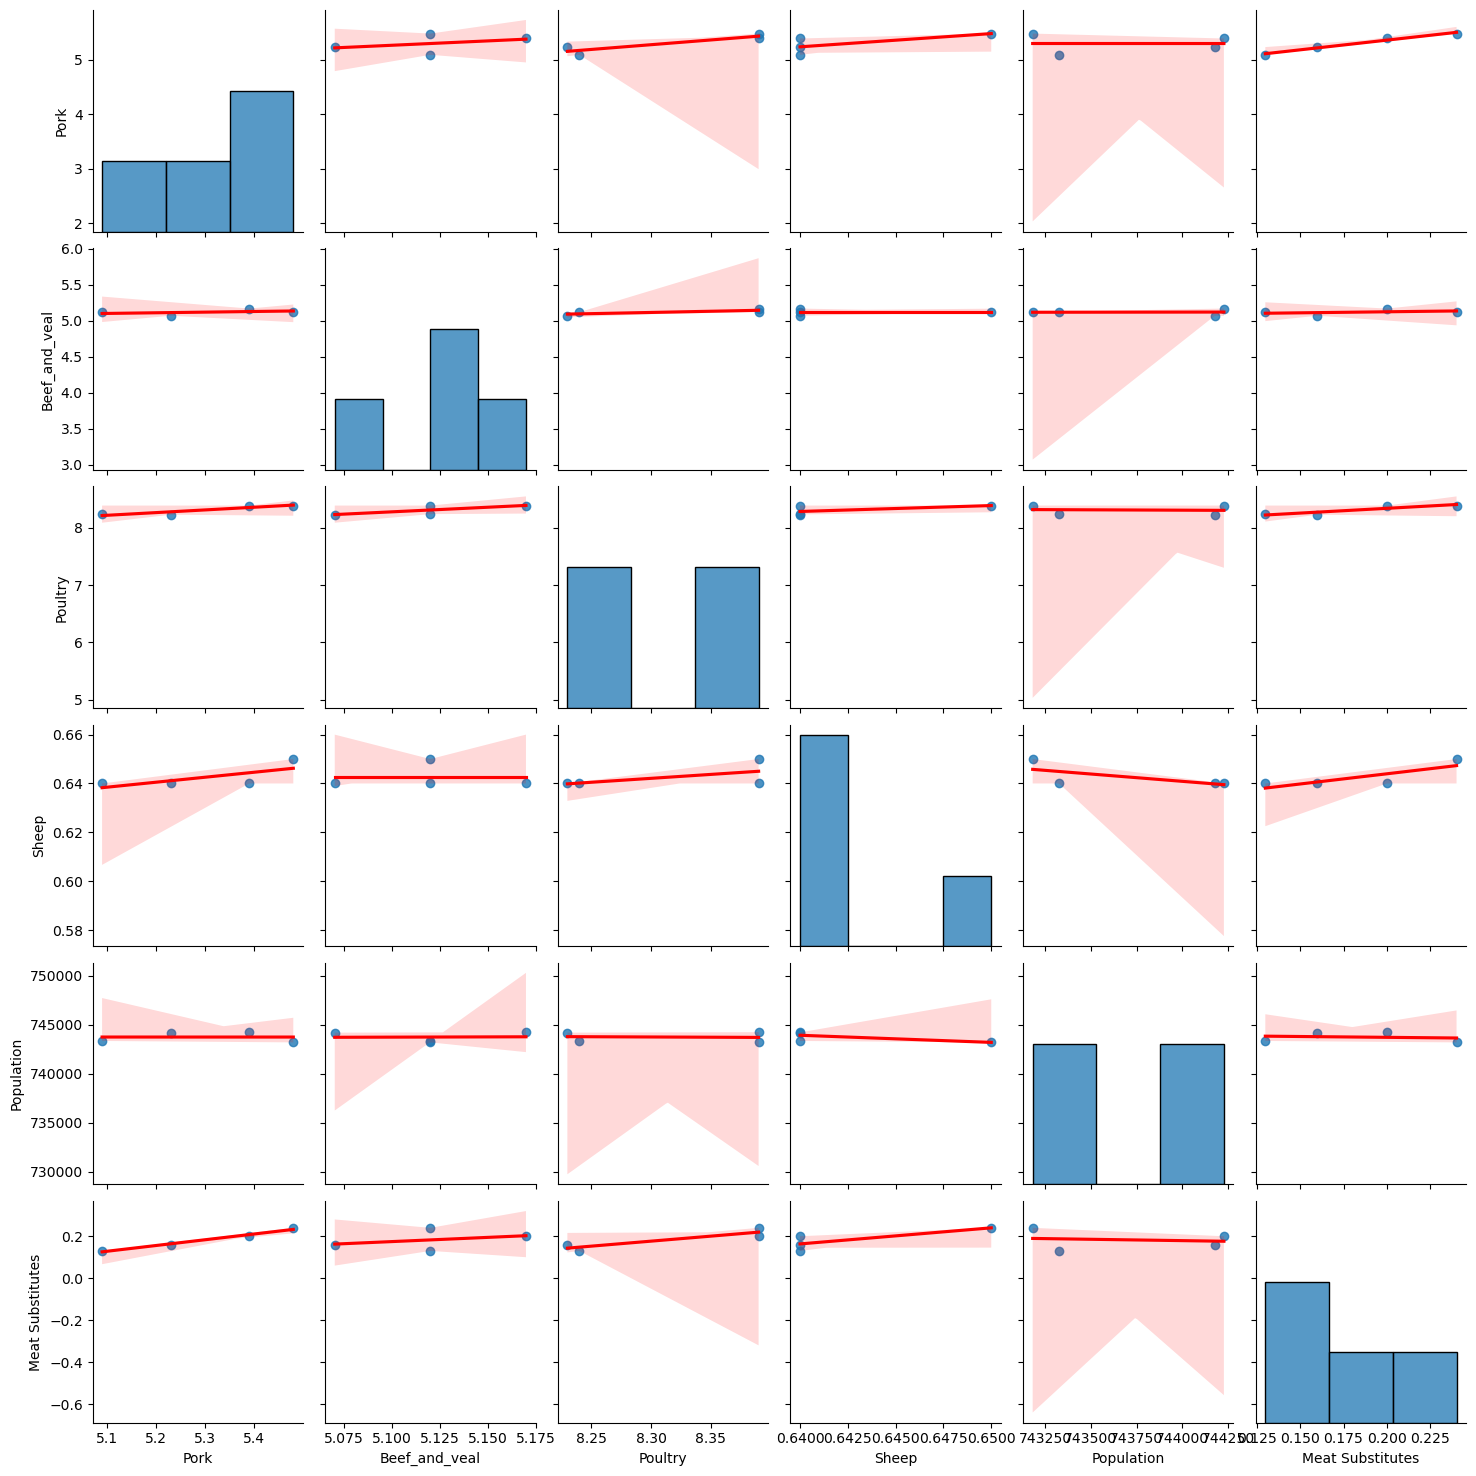

In [36]:
sns.pairplot(new_df, kind='reg', diag_kind= "hist", plot_kws={'line_kws':{'color':'red'}})
plt.savefig("Figures/StatistaPairPlot.svg")
plt.show()

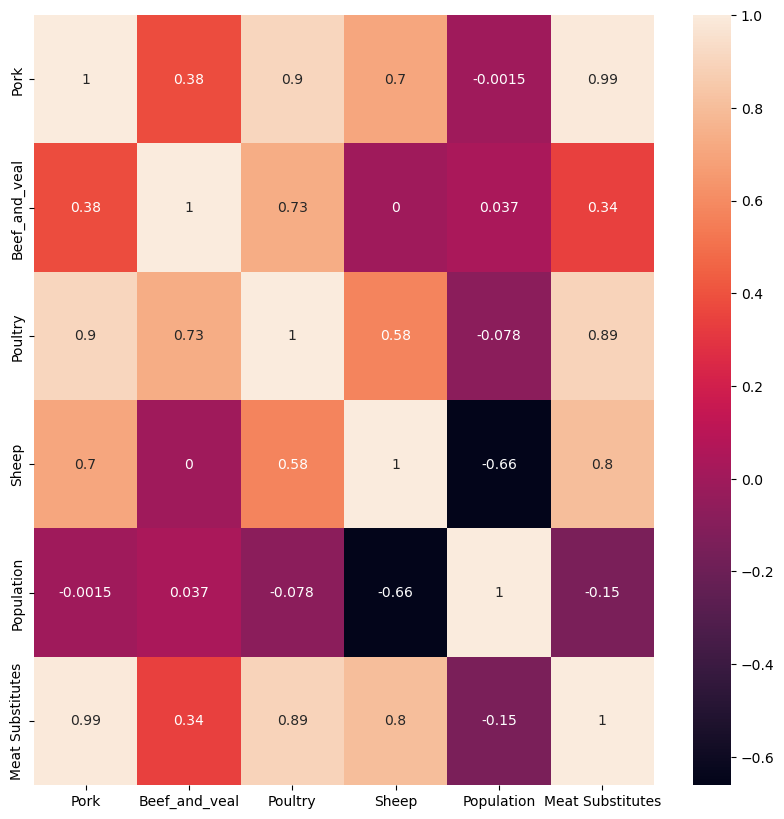

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(new_df.corr(), annot = True)
plt.savefig("Figures/StatistaHeatmap.eps", dpi = 300)
plt.show()

### Data Preprocessing

In [38]:
df_transformed = copy.deepcopy(new_df)
df_transformed.drop('Year', axis = 1, inplace = True)

In [39]:
# Standardising the data

z_scaler = preprocessing.StandardScaler()
df_transformed[:] = z_scaler.fit_transform(df_transformed)
df_transformed

,Pork,Beef_and_veal,Poultry,Sheep,Population,Meat Substitutes
0,-1.387386,0.000000,-0.934512,-0.577350,-0.842474,-1.266348
1,-0.451318,-1.414214,-1.063410,-0.577350,0.941427,-0.542720
2,0.618473,1.414214,0.998961,-0.577350,1.045753,0.422116
3,1.220231,0.000000,0.998961,1.732051,-1.144707,1.386952


### EDA on Standardized Data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


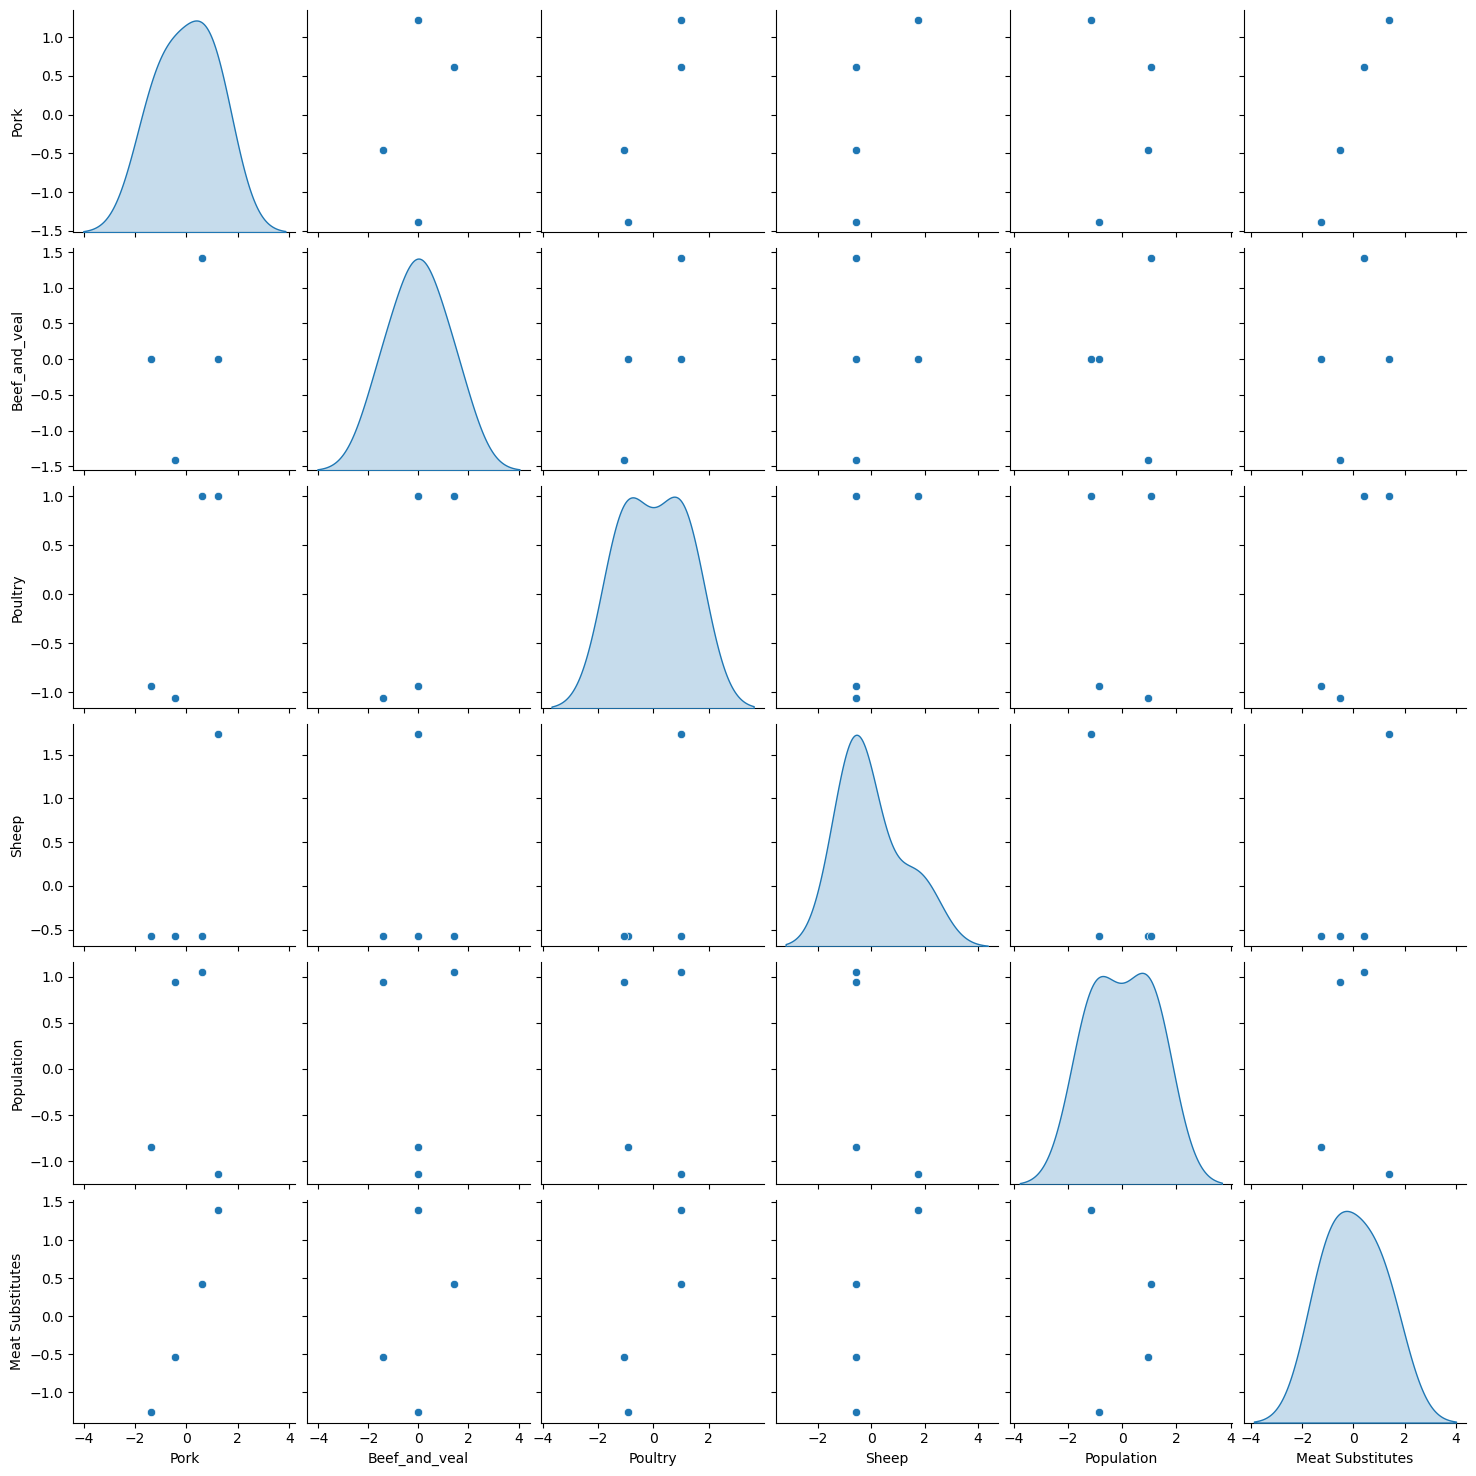

In [40]:
sns.pairplot(df_transformed, diag_kind= "kde")
plt.savefig("Figures/StatistaPairPlotStd.eps", dpi = 300)
plt.show()

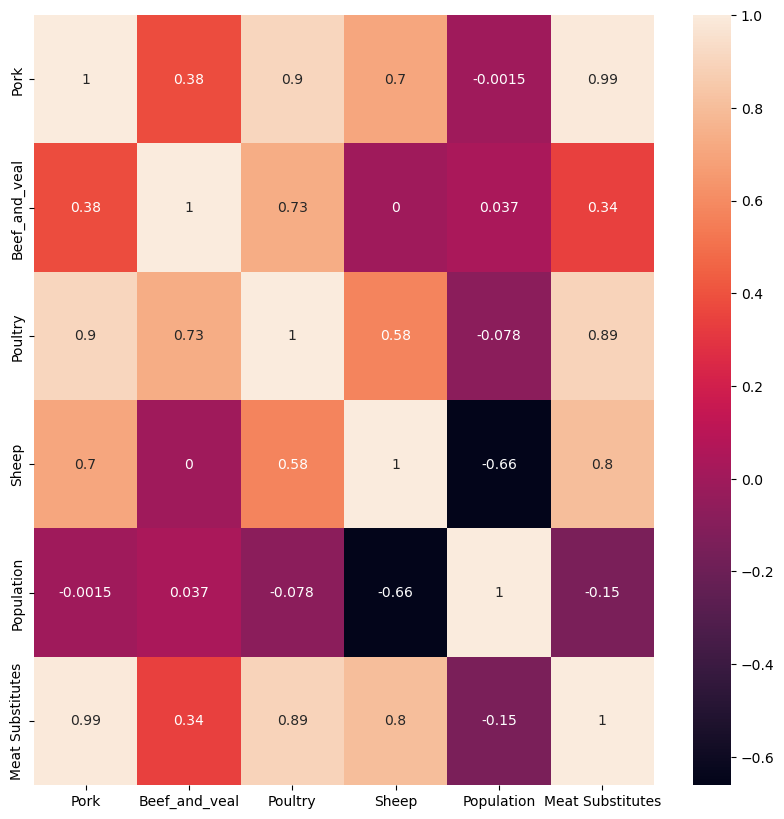

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(df_transformed.corr(), annot = True)
plt.savefig("Figures/StatistaHeatmapStd.eps", dpi = 300)
plt.show()

## Forecasting Plant-Based Meat using XGBoost from 2022 through 2025

In [42]:
X = data.drop(['Year','Meat Substitutes', 'Beef_and_veal', 'Poultry', 'Population'], axis = 1)
y = data['Meat Substitutes']

In [43]:
# Standardising X and y

X_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1,1))

In [44]:
# Creating an instance of the XGBoost model

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

### Data Modelling: XGBoost

In [45]:
# Fitting the XGBoost model

regressor.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
# Predicting on test set

y_pred = regressor.predict(X_test_scaled)
y_pred

array([-0.9990772 ,  0.99907744], dtype=float32)

### Model Evaluation

In [47]:
mean_squared_error(y_test_scaled, y_pred, squared = False) # Calculating RMSE 

1.0102833261089845

In [48]:
r2_score(y_test_scaled, y_pred) # calculating R^2 value

0.21854769450503397

In [49]:
print(regressor.feature_importances_) # Implies the feature for Sheep is not adding any value to the model

[1. 0.]


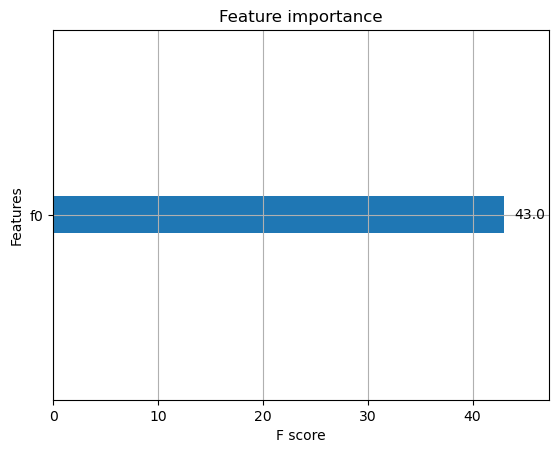

In [50]:
# Feature Importance Plot

xgb.plot_importance(regressor)
plt.show()

#### To understand why the XGBoost model is performing poorly

[[-0.9990776  0.       ]
 [ 0.9990776  0.       ]]


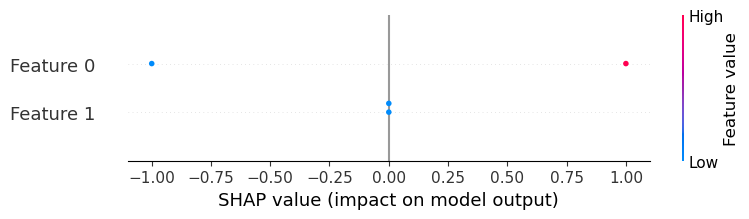

In [51]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_scaled)
print(shap_values)
shap.summary_plot(shap_values, X_train_scaled,show=False)
plt.gcf().savefig("Figures/Shap_plot_XGBoost.eps", format = 'eps', dpi = 300)
plt.show()

### Cross Validation: XGBoost

In [52]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data

X_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1,1))

# Instantiate the regressor
model = xgb.XGBRegressor(objective="reg:squarederror")

# Create LOOCV procedure
loo = LeaveOneOut()
y_true, y_pred_train = list(), list()

# Split training data into train/test sets for LOOCV and train/predict
for train_index, val_index in loo.split(X_train):
    X_train_loo, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_loo, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
    
    # Train the model
    model.fit(X_train_loo, y_train_loo)
    
    # Make a prediction
    yhat = model.predict(X_val)
    
    # Store the true and predicted values
    y_true.append(y_val[0])
    y_pred_train.append(yhat[0])

# Evaluate LOOCV predictions
mse_train = mean_squared_error(y_true, y_pred_train, squared = False)
print('Train RMSE: %.3f' % mse_train)

# Train model on entire training set and evaluate on test set
model.fit(X_train_scaled, y_train_scaled)
y_pred_test = model.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, y_pred_test)

print('Test R2: %.3f' % r2)

Train RMSE: 2.000
Test R2: 0.219


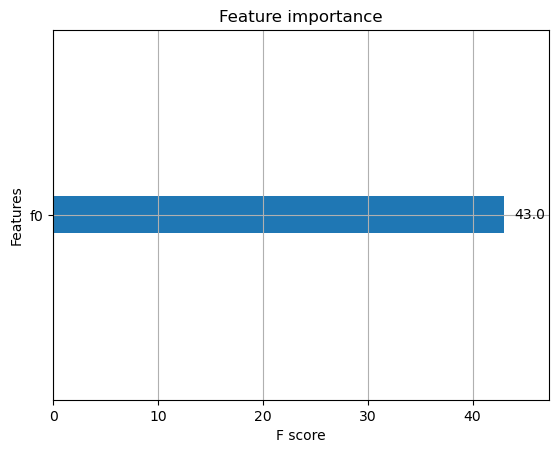

In [53]:
# Feature Importance Plot

xgb.plot_importance(model)
plt.show()

#### Retraining XGBoost model using the entire dataset

In [54]:
X = data.drop(['Year','Meat Substitutes', 'Beef_and_veal', 'Poultry', 'Population'], axis = 1)
y = data['Meat Substitutes']

In [55]:
# Standardising the data

X_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(np.array(y).reshape(-1,1))

In [56]:
# Fitting the XGBoost model

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

regressor.fit(X_scaled, y_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [57]:
print(regressor.feature_importances_) # Determining Feature Importance

[1. 0.]


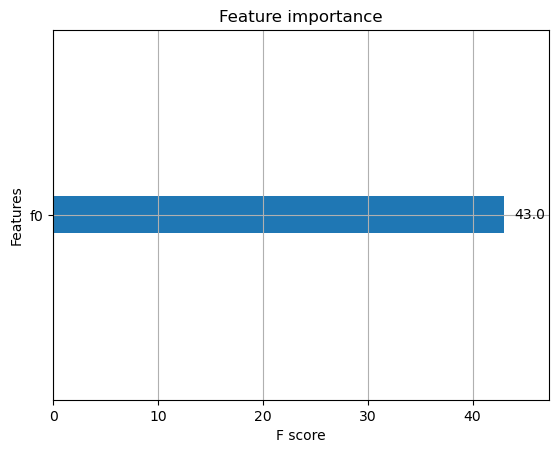

In [58]:
# Feature Importance Plot

xgb.plot_importance(model)
plt.show()

#### Importing Forecasted DataFrame

In [59]:
meat_df = pd.read_csv('Data/VARMAX_Forecast_with_Holt.csv')
meat_df.drop('Unnamed: 0', axis = 1, inplace= True) ## Dropping Column with index as column
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population
0,1990,21638.200000,12415.740000,2054.650000,1809.260000,448805.382000
1,1991,21234.930000,12311.400000,8099.460000,1753.560000,450298.107000
2,1992,20991.890000,15833.920000,9777.320000,2051.710000,688358.946000
3,1993,24072.310000,15307.840000,9799.410000,2070.240000,705070.033000
4,1994,23715.500000,14543.260000,10474.860000,1981.300000,705611.100000
5,1995,23678.540000,13615.010000,11014.160000,1940.390000,705768.653000
6,1996,23315.000000,13149.180000,11370.330000,1894.990000,705842.588000
7,1997,23128.110000,12873.880000,11832.930000,1797.430000,705880.858000
8,1998,24218.650000,12574.530000,12144.540000,1786.360000,705845.172000
9,1999,24154.350000,11856.890000,11998.970000,1759.310000,705683.958000


In [60]:
meat_df.drop(meat_df[meat_df['Year'] < 2022].index, inplace= True) # Dropping data before 2022
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885


In [61]:
meat_df['Year'] = pd.to_datetime(meat_df['Year'], format='%Y').dt.strftime('%Y') # Changing the data type of Year to datetime
meat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 32 to 35
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4 non-null      object 
 1   Pork           4 non-null      float64
 2   Beef_and_veal  4 non-null      float64
 3   Poultry        4 non-null      float64
 4   Sheep          4 non-null      float64
 5   Population     4 non-null      float64
dtypes: float64(5), object(1)
memory usage: 324.0+ bytes


In [62]:
meat_df.head()

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885


In [63]:
df = meat_df.drop(['Year', 'Population'], axis = 1)

df/=1000  # Dividing by 1000 so that unit is now billion kg instead of thousand tonnes
new_df = pd.merge(df, meat_df['Population'],left_index=True, right_index=True)
new_df

,Pork,Beef_and_veal,Poultry,Sheep,Population
32,26.670304,10.450671,21.583143,1.234736,743656.395355
33,26.692162,10.845952,21.783658,1.238179,743715.879589
34,26.710165,10.700403,21.982156,1.218505,743763.466975
35,26.465735,10.554011,22.459850,1.196488,743801.536885


In [64]:
new_df = new_df.drop(['Beef_and_veal', 'Poultry', 'Population'], axis=1)
new_df

,Pork,Sheep
32,26.670304,1.234736
33,26.692162,1.238179
34,26.710165,1.218505
35,26.465735,1.196488


In [65]:
# Standardising the test set

Test_scaled = X_scaler.transform(new_df)
Test_scaled

array([[142.90277044, 136.77099905],
       [143.04891421, 137.56613705],
       [143.16928957, 133.02273071],
       [141.53498262, 127.93795497]])

In [66]:
# Forecasting the PBMA consumption values for 2022-2025

Prediction = regressor.predict(Test_scaled)
Prediction

array([1.3860072, 1.3860072, 1.3860072, 1.3860072], dtype=float32)

In [67]:
# Inverse transforming to get the values in original scale

Meat_substitutes = y_scaler.inverse_transform(np.array(Prediction).reshape(-1, 1))
Meat_substitutes

array([[0.23996082],
       [0.23996082],
       [0.23996082],
       [0.23996082]], dtype=float32)

In [68]:
# Multiplying by 1000 to get the PBMA consumption in thousand tonnes

pbma = Meat_substitutes*1000
meat_df['PBMA'] = pbma

In [69]:
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population,PBMA
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355,239.960815
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589,239.960815
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975,239.960815
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885,239.960815


## Forecasting Plant-Based Meat using Multiple Linear Regression from 2022 through 2025

In [70]:
data.head()

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population,Meat Substitutes
0,2018,5.09,5.12,8.24,0.64,743326.771,0.13
1,2019,5.23,5.07,8.23,0.64,744177.750,0.16
2,2020,5.39,5.17,8.39,0.64,744227.517,0.20
3,2021,5.48,5.12,8.39,0.65,743182.596,0.24


In [71]:
# Splitting the Data into Train and Test Sets

X = data.drop(['Year', 'Beef_and_veal', 'Poultry', 'Population','Meat Substitutes'], axis=1)
y = data['Meat Substitutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Data Modelling: Multiple Linear Regression

In [72]:
# Standardising the Data and Fitting the model

# Create a scaler for X and y
scaler_X = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()

# Fit and transform on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))

# Transform the test data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1,1))

# Train model on the scaled training data
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_scaled)

# Predict on the scaled test data
y_pred_scaled = regressor.predict(X_test_scaled)

# Inverse transform the predicted values to get them back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

### Model Evaluation

In [73]:
coefficients = regressor.coef_
intercept = regressor.intercept_
r_squared = r2_score(y_test_scaled, y_pred_scaled)


print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")
print(f"Model Score: {r_squared}")

Coefficients: [[1. 0.]]
Intercept: [2.94209102e-15]
Model Score: 0.8849652777777797


In [74]:
mse = mean_squared_error(y_test_scaled, y_pred_scaled, squared = False) # Calculating RMSE
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.38762021761844856


In [75]:
## Calculating Variance Inflation Fcator to determine Multicollinearity

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(len(X_train.columns))]
  
print(vif_data)

  feature  VIF
0    Pork  1.0
1   Sheep  NaN


invalid value encountered in double_scalars


### Cross Validation

In [76]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data

X_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1,1))

# Instantiate the regressor
model = LinearRegression()

# Create LOOCV procedure
loo = LeaveOneOut()
y_true, y_pred_train = list(), list()

# Split training data into train/test sets for LOOCV and train/predict
for train_index, val_index in loo.split(X_train):
    X_train_loo, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_loo, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
    
    # Train the model
    model.fit(X_train_loo, y_train_loo)
    
    # Make a prediction
    yhat = model.predict(X_val)
    
    # Store the true and predicted values
    y_true.append(y_val[0])
    y_pred_train.append(yhat[0])

# Evaluate LOOCV predictions
mse_train = mean_squared_error(y_true, y_pred_train, squared = False)
print('Train RMSE: %.3f' % mse_train)

# Train model on entire training set and evaluate on test set
model.fit(X_train_scaled, y_train_scaled)
y_pred_test = model.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, y_pred_test)

print('Test R2: %.3f' % r2)

Train RMSE: 2.000
Test R2: 0.885


#### Retraining Multiple Linear Regression model using the entire dataset

In [77]:
X = data.drop(['Year', 'Beef_and_veal', 'Poultry', 'Population','Meat Substitutes'], axis=1)
y = data['Meat Substitutes']

In [78]:
# Standardising the Data
scaler_X = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))

# Train the model on the scaled training data
regressor = LinearRegression()
regressor.fit(X_scaled, y_scaled)

LinearRegression()

In [79]:
# Model Parameters

coefficients = regressor.coef_
intercept = regressor.intercept_

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: [[0.84318892 0.20673009]]
Intercept: [-1.26741613e-15]


#### Importing Forecasted DataFrame

In [80]:
meat_df = pd.read_csv('Data/VARMAX_Forecast_with_Holt.csv')
meat_df.drop('Unnamed: 0', axis = 1, inplace= True) ## Dropping Column with index as column
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population
0,1990,21638.200000,12415.740000,2054.650000,1809.260000,448805.382000
1,1991,21234.930000,12311.400000,8099.460000,1753.560000,450298.107000
2,1992,20991.890000,15833.920000,9777.320000,2051.710000,688358.946000
3,1993,24072.310000,15307.840000,9799.410000,2070.240000,705070.033000
4,1994,23715.500000,14543.260000,10474.860000,1981.300000,705611.100000
5,1995,23678.540000,13615.010000,11014.160000,1940.390000,705768.653000
6,1996,23315.000000,13149.180000,11370.330000,1894.990000,705842.588000
7,1997,23128.110000,12873.880000,11832.930000,1797.430000,705880.858000
8,1998,24218.650000,12574.530000,12144.540000,1786.360000,705845.172000
9,1999,24154.350000,11856.890000,11998.970000,1759.310000,705683.958000


In [81]:
meat_df.drop(meat_df[meat_df['Year'] < 2022].index, inplace= True) # Dropping data before 2010
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885


In [82]:
meat_df['Year'] = pd.to_datetime(meat_df['Year'], format = '%Y').dt.strftime('%Y')
meat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 32 to 35
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4 non-null      object 
 1   Pork           4 non-null      float64
 2   Beef_and_veal  4 non-null      float64
 3   Poultry        4 non-null      float64
 4   Sheep          4 non-null      float64
 5   Population     4 non-null      float64
dtypes: float64(5), object(1)
memory usage: 324.0+ bytes


In [83]:
df = meat_df.drop(['Year', 'Population'], axis = 1)

df/=1000  # Dividing by 1000 so that unit is now billion kg instead of thousand tonnes
new_df = pd.merge(df, meat_df['Population'],left_index=True, right_index=True)
new_df


,Pork,Beef_and_veal,Poultry,Sheep,Population
32,26.670304,10.450671,21.583143,1.234736,743656.395355
33,26.692162,10.845952,21.783658,1.238179,743715.879589
34,26.710165,10.700403,21.982156,1.218505,743763.466975
35,26.465735,10.554011,22.459850,1.196488,743801.536885


In [84]:
new_df = new_df.drop(['Beef_and_veal', 'Poultry', 'Population'], axis=1) # Dropping columns not used for forecasting
new_df

,Pork,Sheep
32,26.670304,1.234736
33,26.692162,1.238179
34,26.710165,1.218505
35,26.465735,1.196488


In [85]:
# Standardising the data for future forecasts

Test_scaled = scaler_X.transform(new_df)
Test_scaled

array([[142.90277044, 136.77099905],
       [143.04891421, 137.56613705],
       [143.16928957, 133.02273071],
       [141.53498262, 127.93795497]])

In [86]:
# Future Forecasts of PBMA Consumption (2022-2025)

Pred = regressor.predict(Test_scaled)
Pred

array([[148.76871452],
       [149.05632029],
       [148.21856064],
       [145.78935496]])

In [87]:
# Inverse Transforming the forecasts to get values in original scale

Meat_substitutes = scaler_y.inverse_transform(np.array(Pred).reshape(-1, 1))
Meat_substitutes

array([[6.35012508],
       [6.36204859],
       [6.32731691],
       [6.22660736]])

In [88]:
# Multiplying by 1000 to get the PBMA consumption in thousand tonnes

pbma = Meat_substitutes*1000
pbma

array([[6350.12508246],
       [6362.04858774],
       [6327.31690759],
       [6226.60736057]])

In [89]:
meat_df['PBMA'] = pbma # Forecasts from 2022-2025
meat_df

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population,PBMA
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355,6350.125082
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589,6362.048588
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975,6327.316908
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885,6226.607361


In [94]:
df = copy.deepcopy(meat_df)
df.head()

,Year,Pork,Beef_and_veal,Poultry,Sheep,Population,PBMA
32,2022,26670.304161,10450.671233,21583.143101,1234.735798,743656.395355,6350.125082
33,2023,26692.161697,10845.952097,21783.658412,1238.178847,743715.879589,6362.048588
34,2024,26710.165259,10700.402600,21982.155589,1218.505320,743763.466975,6327.316908
35,2025,26465.735271,10554.011435,22459.850265,1196.487596,743801.536885,6226.607361


In [95]:
# Changing the data format from Wide => Long

long_df = pd.melt(df, id_vars = 'Year', value_vars = ['Pork', 'Beef_and_veal', 'Poultry', 'Sheep', 'PBMA'], value_name = 'Consumption', var_name = 'Meat_Type')
new_df = copy.deepcopy(long_df)
long_df

,Year,Meat_Type,Consumption
0,2022,Pork,26670.304161
1,2023,Pork,26692.161697
2,2024,Pork,26710.165259
3,2025,Pork,26465.735271
4,2022,Beef_and_veal,10450.671233
5,2023,Beef_and_veal,10845.952097
6,2024,Beef_and_veal,10700.402600
7,2025,Beef_and_veal,10554.011435
8,2022,Poultry,21583.143101
9,2023,Poultry,21783.658412


In [96]:
long_df.drop(long_df[long_df['Year'] < '2025'].index, inplace= True) # Dropping data before 2025
long_df

,Year,Meat_Type,Consumption
3,2025,Pork,26465.735271
7,2025,Beef_and_veal,10554.011435
11,2025,Poultry,22459.850265
15,2025,Sheep,1196.487596
19,2025,PBMA,6226.607361


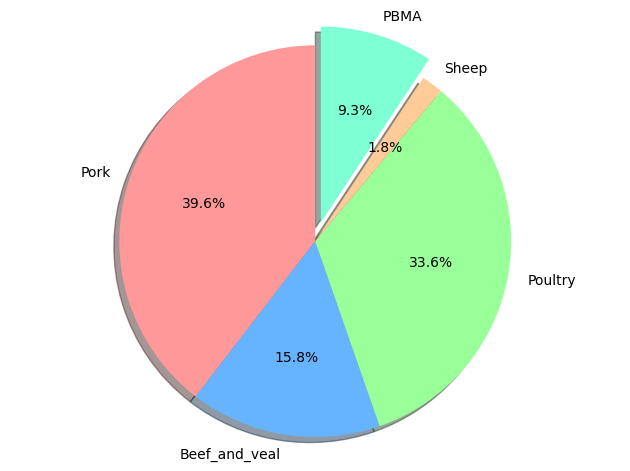

In [101]:
# only "explode" the last slice (i.e. 'PBMA')
explode = (0, 0, 0, 0, 0.1)
#add colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#7FFFD4']
fig1, ax1 = plt.subplots()
ax1.pie(long_df['Consumption'], explode=explode, labels=long_df['Meat_Type'], colors = colors, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.savefig("Figures/pie_chart.svg")
plt.show()